In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import scikitplot as skplt

In [169]:
# Figure out why seperator is not working
# df = pd.read_csv('/Users/lakshyagarg/Downloads/stage2_qas_case_study/Marketing Campaign Data.csv',delimiter = ';')

df = pd.read_csv('/Users/lakshyagarg/Downloads/changed/Marketing Campaign Data.csv',delimiter = ',')

In [170]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,36.0,management,married,tertiary,no,101,yes,yes,unknown,5,may,426,1,-1,0,unknown,no
1,57.0,technician,married,unknown,no,206,yes,no,unknown,5,may,216,3,-1,0,unknown,no
2,54.0,services,married,secondary,yes,0,yes,no,unknown,6,may,138,3,-1,0,unknown,no
3,51.0,blue-collar,married,secondary,no,50,yes,yes,unknown,6,may,121,1,-1,0,unknown,no
4,49.0,technician,married,unknown,no,15,no,no,unknown,6,may,92,2,-1,0,unknown,no


In [171]:
print (df.shape)

(42600, 17)


# Data Cleaning

In [172]:
print(df.isna().sum())

age          2656
job          1409
marital      1338
education     660
default         0
balance         0
housing         0
loan         2596
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
dtype: int64


In [173]:
for x in df.columns:
    print ('#####################################')
    print ('column name:',x)
    print (df[x].unique())
    print ('#####################################')

#####################################
column name: age
[36. 57. 54. 51. 49. 39. 35. 42. 40. 44. 43. 27. 29. 55. 46. 41. 37. 31.
 30. 47. 28. 32. 38. 26. 25. 53. 60. 34. 45. 50. 33. 58. 22. 21. 24. 48.
 56. 52. 59. 66. 62. 67. 63. 64. 82. 73. 95. 77. 19. 76. 72. 74. 84. 23.
 65. 70. 61. 75. 79. 83. 71. nan 78. 18. 68. 20. 80. 81. 85. 69. 86. 94.
 93. 89. 88. 90.]
#####################################
#####################################
column name: job
['management' 'technician' 'services' 'blue-collar' 'admin.' 'unemployed'
 'self-employed' 'retired' 'entrepreneur' 'student' 'housemaid' 'unknown'
 nan]
#####################################
#####################################
column name: marital
['married' 'single' 'divorced' nan]
#####################################
#####################################
column name: education
['tertiary' 'unknown' 'secondary' 'primary' nan]
#####################################
#####################################
column name: default
['no' 'yes

In [174]:
# Replacing Nans
df['job'] =  df['job'].fillna('unknown')

# Assumption changed unknown to uknown too ##### CHECK AGAIN #####
df['marital'] =  df['marital'].fillna('unknown')

df['education'] =  df['education'].fillna('unknown')

df['loan'] =  df['loan'].fillna('no')

In [175]:
# Checking distribution of continious columns balance (3217 entries balance < 0) and duration 
print (df[["balance", "duration","age"]].describe())

             balance      duration           age
count   42600.000000  42600.000000  39944.000000
mean     1329.301643    256.533310     40.725015
std      2999.014702    257.911496     10.162608
min     -8019.000000      0.000000     18.000000
25%        65.000000    102.000000     33.000000
50%       432.000000    178.000000     39.000000
75%      1384.250000    317.000000     48.000000
max    102127.000000   4918.000000     95.000000


In [176]:
# Replacing p days value of -1 to 0 for 35776 entries
df_p = df[df['pdays'] == -1]
print (df_p.shape)
df['pdays'] = df['pdays'].apply(lambda x: 0 if x == -1 else x)

(35776, 17)


In [177]:
# Checking the count of distinct values in outcome column
df_g_outcome = df.groupby(['poutcome']).size()
df_p_g_outcome = df_p.groupby(['poutcome']).size()
print (df_g_outcome.head(10))
print ('######')
print (df_p_g_outcome.head(10))

poutcome
failure     4315
other       1592
success      914
unknown    35779
dtype: int64
######
poutcome
unknown    35776
dtype: int64


In [178]:
# y group by shape
# This is an imbalanced classification problem
df_y = df.groupby(df['y']).size()
df_y.head(10)

y
no     38400
yes     4200
dtype: int64

In [179]:
# dropping those rows where age is NA as age cannot be imputed
df = df.dropna(subset=['age'])
df['job'] = df['job'].apply(lambda x: 'admin' if x == 'admin.' else x)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
print (df.shape)

(39944, 17)


# EDA

In [180]:
df_eda = df.copy()

In [181]:
def buckets(x):
    x = int(x)
    a = ''
    if x >= 0 and x < 15:
        a = '0 to 15'
    elif x >= 15 and x < 30:
        a = '15 to 30'
    elif x >= 30 and x < 45:
        a = '30 to 45'
    elif x >= 45 and x < 60:
        a = '45 to 60'
    elif x >= 60 and x < 75:
        a = '60 to 75'
    elif x >= 75 and x < 90:
        a = '75 to 90'
    else:
        a = '90 to 105'
    return a

df_eda['age_buckets'] = df_eda['age'].apply(buckets)

In [182]:
df_age_groupby = df_eda.groupby(['age_buckets']).agg({'age':'size', 'y':'sum'})
df_age_groupby = df_age_groupby.reset_index()
df_age_groupby.columns = ['age_buckets', 'number_of_people','conversions']
df_age_groupby['conversion_percent'] = round((df_age_groupby['conversions']/df_age_groupby['number_of_people'])*100,2)
print (df_age_groupby['number_of_people'].sum())


df_jobs_groupby = df_eda.groupby(['job']).agg({'age':'size', 'y':'sum'})
df_jobs_groupby = df_jobs_groupby.reset_index()
df_jobs_groupby.columns = ['jobs', 'number_of_people','conversions']
df_jobs_groupby['conversion_percent'] = round((df_jobs_groupby['conversions']/df_jobs_groupby['number_of_people'])*100,2)
print (df_jobs_groupby['number_of_people'].sum())



df_eda_martial_filter = df_eda[ df_eda['education'] == 'tertiary']
df_Maritial_groupby = df_eda_martial_filter.groupby(['marital']).agg({'age':'size', 'y':'sum'})
df_Maritial_groupby = df_Maritial_groupby.reset_index()
df_Maritial_groupby.columns = ['marital', 'number_of_people','conversions']
df_Maritial_groupby['conversion_percent'] = round((df_Maritial_groupby['conversions']/df_Maritial_groupby['number_of_people'])*100,2)
print (df_Maritial_groupby['number_of_people'].sum())


df_education_groupby = df_eda.groupby(['education']).agg({'age':'size', 'y':'sum'})
df_education_groupby = df_education_groupby.reset_index()
df_education_groupby.columns = ['education', 'number_of_people','conversions']
df_education_groupby['conversion_percent'] = round((df_education_groupby['conversions']/df_education_groupby['number_of_people'])*100,2)
print (df_education_groupby['number_of_people'].sum())


df_month_groupby = df_eda.groupby(['month']).agg({'age':'size', 'y':'sum'})
df_month_groupby = df_month_groupby.reset_index()
df_month_groupby.columns = ['month', 'number_of_people','conversions']
df_month_groupby['conversion_percent'] = round((df_month_groupby['conversions']/df_month_groupby['number_of_people'])*100,2)

print (df_month_groupby['number_of_people'].sum())


39944
39944
11428
39944
39944


In [183]:
df_age_groupby.head(10)

,age_buckets,number_of_people,conversions,conversion_percent
0,15 to 30,4492,665,14.80
1,30 to 45,21827,1921,8.80
2,45 to 60,12459,1000,8.03
3,60 to 75,1002,277,27.64
4,75 to 90,159,67,42.14
5,90 to 105,5,3,60.00


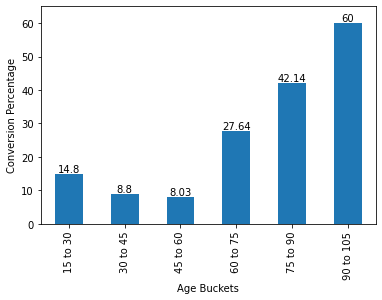

In [184]:
# Age bucket distribution
ax = df_age_groupby.plot(x="age_buckets", y=["conversion_percent"], kind="bar", legend=False)
ax.bar_label(ax.containers[0], label_type='edge')
# plt.title ('Converion rate X Age Distribution')
plt.ylim(0, 65)
plt.xlabel ('Age Buckets')
plt.ylabel ('Conversion Percentage')
plt.show()

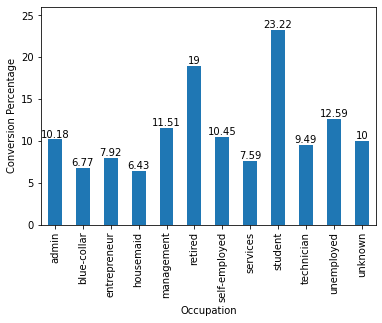

In [185]:
# Jobs distribution
ax = df_jobs_groupby.plot(x="jobs", y=["conversion_percent"], kind="bar", legend=False)
ax.bar_label(ax.containers[0], label_type='edge')
# plt.title ('Phone calls X Job Distribution')
plt.xlabel ('Occupation')
plt.ylabel ('Conversion Percentage')
plt.ylim(0, 26)
plt.show()

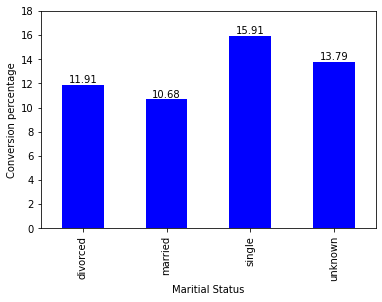

In [186]:
# Maritial distribution


ax = df_Maritial_groupby.plot(x="marital", y=["conversion_percent"], kind="bar", legend=False, color = 'blue')
ax.bar_label(ax.containers[0], label_type='edge')
# plt.title ('Phone calls X Married status')
plt.xlabel ('Maritial Status')
plt.ylim(0, 18)
plt.ylabel ('Conversion percentage')
plt.show()

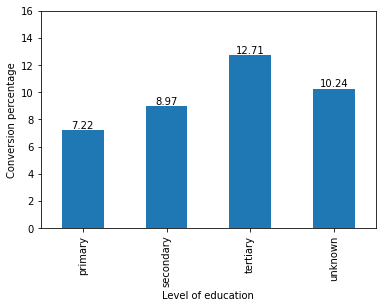

In [187]:
# Education distribution

# colors = ["blue" if i == 'tertiary' else "cyan" for i in df_education_groupby['education']]


ax = df_education_groupby.plot(x="education", y=["conversion_percent"], kind="bar", legend=False)
ax.bar_label(ax.containers[0], label_type='edge')
# plt.title ('Phone calls X Education level')
plt.xlabel ('Level of education')
plt.ylim(0, 16)
plt.ylabel ('Conversion percentage')
plt.show()

In [188]:
df_education_groupby.head(10)

,education,number_of_people,conversions,conversion_percent
0,primary,6035,436,7.22
1,secondary,20314,1823,8.97
2,tertiary,11428,1452,12.71
3,unknown,2167,222,10.24


# Time distribution

In [189]:
d = {
    'apr':4, 'aug':8, 'dec':12, 'feb':2, 'jan':1, 'jul':7, 'jun':6, 'mar':3, 'may':5,
       'nov':11, 'oct':10, 'sep':9}
df_month_groupby.month = df_month_groupby.month.map(d)
df_month_groupby.sort_values(by='month',inplace=True)

In [190]:
df_month_groupby.head(5)
# MONTH HAS NO ADDITIONAL EFFECT SO NOT TAKING IT IN THE MODELING PROCESS

,month,number_of_people,conversions,conversion_percent
4,1,1181,76,6.44
3,2,2324,325,13.98
7,3,347,181,52.16
0,4,2623,493,18.80
8,5,12571,796,6.33


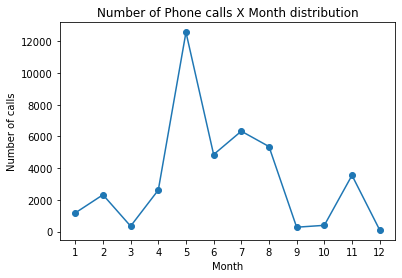

In [191]:
ax = df_month_groupby.plot(x="month", y=["number_of_people"], kind="line", legend=False, style='o-')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.title ('Number of Phone calls X Month distribution')
plt.xlabel ('Month')
plt.ylabel ('Number of calls')
plt.xticks(df_month_groupby['month'])
plt.show()

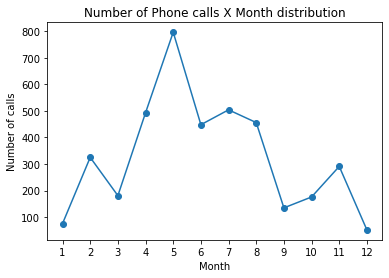

In [192]:
ax = df_month_groupby.plot(x="month", y=["conversions"], kind="line", legend=False, style='o-')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.title ('Number of Phone calls X Month distribution')
plt.xlabel ('Month')
plt.ylabel ('Number of calls')
plt.xticks(df_month_groupby['month'])
plt.show()

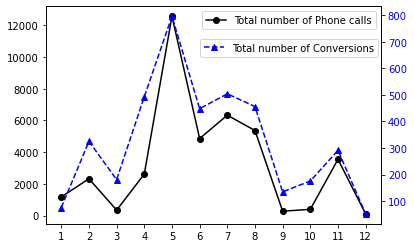

In [193]:

fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(df_month_groupby['month'], df_month_groupby['number_of_people'], color='black', marker='o', label='Total number of Phone calls')
ax.tick_params(axis='y', labelcolor='black')
plt.legend()
# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(df_month_groupby['month'], df_month_groupby['conversions'], color='blue', marker='^', linestyle='--',label='Total number of Conversions')
ax2.tick_params(axis='y', labelcolor='blue')




plt.xticks(df_month_groupby['month'])
plt.legend(bbox_to_anchor=(0.46, 0.85), loc='upper left', borderaxespad=0)

plt.savefig('time.png')
plt.xlabel ('Month')
plt.show()




# MODEL

In [194]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,36.0,management,married,tertiary,no,101,yes,yes,unknown,5,may,426,1,0,0,unknown,0
1,57.0,technician,married,unknown,no,206,yes,no,unknown,5,may,216,3,0,0,unknown,0
2,54.0,services,married,secondary,yes,0,yes,no,unknown,6,may,138,3,0,0,unknown,0
3,51.0,blue-collar,married,secondary,no,50,yes,yes,unknown,6,may,121,1,0,0,unknown,0
4,49.0,technician,married,unknown,no,15,no,no,unknown,6,may,92,2,0,0,unknown,0


In [196]:
# Converting columns into one hot encoding
job_dummies = pd.get_dummies(df.job, prefix='job')
marital_dummies = pd.get_dummies(df.marital, prefix='marital')
education_dummies = pd.get_dummies(df.education, prefix='education')
default_dummies = pd.get_dummies(df.default, prefix='default')
housing_dummies = pd.get_dummies(df.housing, prefix='housing')
loan_dummies = pd.get_dummies(df.loan, prefix='loan')
contact_dummies = pd.get_dummies(df.contact, prefix='contact')
poutcome_dummies = pd.get_dummies(df.poutcome, prefix='poutcome')
month_dummies = pd.get_dummies(df.month, prefix='month_')
campaign_dummies = pd.get_dummies(df.campaign, prefix='campaign_')



# Getting day of week from day column as the year is not given assuming the following distribution
def week_of_month(x):
    x = int(x)
    a = 0
    if x >= 0 and x < 7:
        a = 1
    elif x >= 7 and x < 14:
        a = 2
    elif x >= 14 and x < 21:
        a = 3
    else:
        a = 4
    return a
        
df['week_of_month'] = df['day'].apply(week_of_month)

week_of_month_dummies = pd.get_dummies(df.week_of_month, prefix='week_of_month')



In [197]:
df_final_train = df.drop(['job','marital','education','default','housing','loan','contact','poutcome','day','month','campaign','week_of_month']                                   
    , axis = 'columns')

In [198]:
df_final_train = pd.concat([df_final_train, job_dummies,marital_dummies,education_dummies
           ,default_dummies,housing_dummies,loan_dummies,contact_dummies,poutcome_dummies, month_dummies,week_of_month_dummies,
                            campaign_dummies
                    ], axis= 'columns')

In [199]:
df_final_train.head(5)

,age,balance,duration,pdays,previous,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,campaign__39,campaign__41,campaign__43,campaign__44,campaign__46,campaign__50,campaign__51,campaign__55,campaign__58,campaign__63
0,36.0,101,426,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,57.0,206,216,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,54.0,0,138,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51.0,50,121,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,49.0,15,92,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
# Cjecking data types post creation of test and train set
df_final_train.dtypes

age             float64
balance           int64
duration          int64
pdays             int64
previous          int64
                 ...   
campaign__50      uint8
campaign__51      uint8
campaign__55      uint8
campaign__58      uint8
campaign__63      uint8
Length: 103, dtype: object

In [201]:
X = df_final_train.drop(['y'], axis = 'columns')
y = df_final_train['y']

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [204]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(31955, 102)
(31955,)
(7989, 102)
(7989,)


# Logistic Regression model

In [205]:
# Normlizing data for Logistic regression
scaler = StandardScaler()
X_train_minmax = pd.DataFrame(scaler.fit_transform(X_train),columns=list(X_train.columns))
X_test_minmax = pd.DataFrame(scaler.fit_transform(X_test),columns=list(X_test.columns))

In [206]:
# Creating a dictionary for logistic regression hyperparameters
warnings.filterwarnings("ignore", category = UserWarning)
max_iter_options = [1000]
penalty_options = ["l1", "l2"]
solver_options = ['saga']
C_options = [100,500,1000,5000,10000]
class_weight_options = [{0: 1, 1:10}]
lr_param_grid = dict(penalty = penalty_options, C = C_options, max_iter = max_iter_options, solver = solver_options, class_weight = class_weight_options )


In [207]:
logistic_reg =  LogisticRegression()
clf_lr = GridSearchCV(logistic_reg, lr_param_grid, cv = 3, scoring = 'balanced_accuracy')
clf_lr.fit(X_train_minmax,y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [100, 500, 1000, 5000, 10000],
                         'class_weight': [{0: 1, 1: 10}], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             scoring='balanced_accuracy')

In [208]:
print (clf_lr.best_score_)
print (clf_lr.best_params_)
print (clf_lr.best_estimator_)
logistic_regression_all_results = (pd.DataFrame(clf_lr.cv_results_))

0.8419720857899545
{'C': 100, 'class_weight': {0: 1, 1: 10}, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
LogisticRegression(C=100, class_weight={0: 1, 1: 10}, max_iter=1000,
                   penalty='l1', solver='saga')


In [209]:
print(clf_lr.best_score_)

0.8419720857899545


In [210]:
# Retraining the RFC classifier on the best hyperparameters post grid search
clf_tuned_lr = clf_lr.best_estimator_
clf_tuned_lr.fit(X_train_minmax, y_train)


LogisticRegression(C=100, class_weight={0: 1, 1: 10}, max_iter=1000,
                   penalty='l1', solver='saga')

In [282]:
# y_pred_lr = clf_tuned_lr.predict(X_test_minmax)
y_pred_lr = (clf_tuned_lr.predict_proba(X_test)[:,1] >= 0.67).astype(bool)

print(classification_report(y_test, y_pred_lr, labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.35      0.52      0.42       761
           0       0.95      0.90      0.92      7228

    accuracy                           0.86      7989
   macro avg       0.65      0.71      0.67      7989
weighted avg       0.89      0.86      0.87      7989



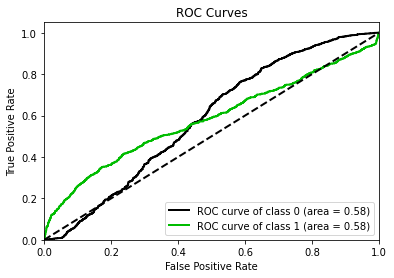

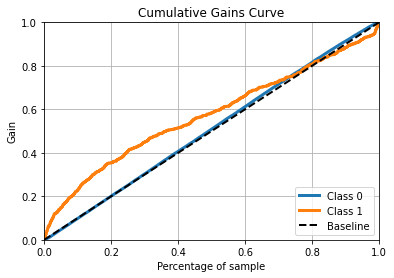

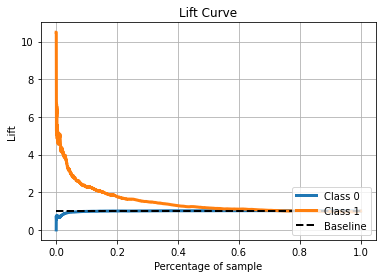

In [212]:
#LR curves

skplt.metrics.plot_roc(y_test, clf_tuned_lr.predict_proba(X_test_minmax), plot_micro =False, plot_macro = False)

skplt.metrics.plot_cumulative_gain(y_test, clf_tuned_lr.predict_proba(X_test_minmax))

skplt.metrics.plot_lift_curve(y_test, clf_tuned_lr.predict_proba(X_test_minmax))

plt.show()


# Random forest model

In [213]:
NFOLDS = 3
SEED = 0
NROWS = None

rfc = RandomForestClassifier(random_state = 42)

rf_params = {
    'n_jobs': [-1],
    'n_estimators': [200,400],
    'max_features': [0.2,0.6,0.9],
    'max_depth': [12,16,20,24],
    'min_samples_leaf': [2,6,10],
    'class_weight':[{0: 1, 1:10}]
}

In [214]:
clf_rf = GridSearchCV(rfc, rf_params, cv = NFOLDS, scoring='balanced_accuracy')
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': [{0: 1, 1: 10}],
                         'max_depth': [12, 16, 20, 24],
                         'max_features': [0.2, 0.6, 0.9],
                         'min_samples_leaf': [2, 6, 10],
                         'n_estimators': [200, 400], 'n_jobs': [-1]},
             scoring='balanced_accuracy')

In [215]:
print (clf_rf.best_score_)
print (clf_rf.best_params_)
print (clf_rf.best_estimator_)
random_forest_all_results = (pd.DataFrame(clf_rf.cv_results_))

0.8550389838010267
{'class_weight': {0: 1, 1: 10}, 'max_depth': 20, 'max_features': 0.2, 'min_samples_leaf': 10, 'n_estimators': 200, 'n_jobs': -1}
RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=20,
                       max_features=0.2, min_samples_leaf=10, n_estimators=200,
                       n_jobs=-1, random_state=42)


In [265]:
# Retraining the RFC classifier on the best hyperparameters post grid search
clf_tuned_rf = clf_rf.best_estimator_
clf_tuned_rf.fit(X_train, y_train)
# y_pred_rf = clf_tuned_rf.predict(X_test)

In [273]:
y_pred_rf = (clf_tuned_rf.predict_proba(X_test)[:,1] >= 0.67).astype(bool)

In [274]:
print(classification_report(y_test, y_pred_rf, labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.51      0.68      0.58       761
           0       0.97      0.93      0.95      7228

    accuracy                           0.91      7989
   macro avg       0.74      0.81      0.76      7989
weighted avg       0.92      0.91      0.91      7989



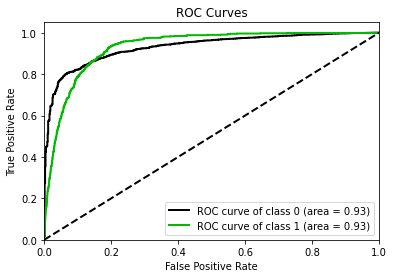

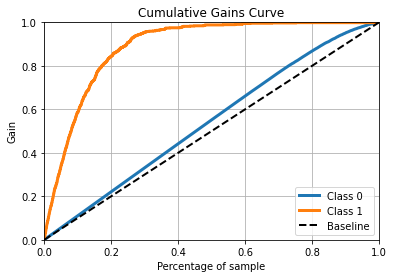

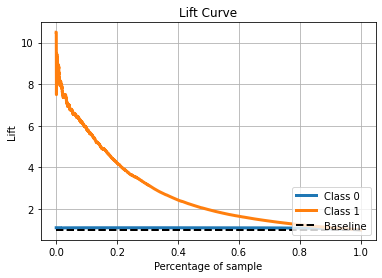

In [218]:
#RF curves

skplt.metrics.plot_roc(y_test, clf_tuned_rf.predict_proba(X_test), plot_micro =False, plot_macro = False)

skplt.metrics.plot_cumulative_gain(y_test, clf_tuned_rf.predict_proba(X_test))

skplt.metrics.plot_lift_curve(y_test, clf_tuned_rf.predict_proba(X_test))

plt.show()

# XG boost 

In [219]:
xgbc_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [5, 10, 15],
    'subsample': [0.2,0.6, 1],
    'lambda':[100,1000],
    'alpha': [100,1000]
    }

In [220]:
xgbc = xgb.XGBClassifier(scale_pos_weight = 10, random_state=42)

In [221]:
# clf_xg = GridSearchCV(xgbc, xgbc_grid, cv = 3, scoring='balanced_accuracy')
clf_xg = BayesSearchCV(xgbc, xgbc_grid,n_iter = 30, cv = 3, scoring='balanced_accuracy',  random_state=123)
clf_xg.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, gamma=None, gpu_id=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_bin=None,
                                      max_c...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
          

In [222]:
print (clf_xg.best_score_)
print (clf_xg.best_params_)
print (clf_xg.best_estimator_)
xg_boost_all_results = (pd.DataFrame(clf_xg.cv_results_))

0.866733095540629
OrderedDict([('alpha', 102), ('lambda', 128), ('max_depth', 10), ('n_estimators', 300), ('subsample', 0.6)])
XGBClassifier(alpha=102, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=128,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)


In [267]:
# Retraining the RFC classifier on the best hyperparameters post grid search
clf_tuned_xg = clf_xg.best_estimator_
clf_tuned_xg.fit(X_train, y_train)
# y_pred_xg = clf_tuned_xg.predict(X_test)

In [277]:
y_pred_xg = (clf_tuned_xg.predict_proba(X_test)[:,1] >= 0.67).astype(bool)

In [278]:
print(classification_report(y_test, y_pred_xg, labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.45      0.80      0.58       761
           0       0.98      0.90      0.94      7228

    accuracy                           0.89      7989
   macro avg       0.71      0.85      0.76      7989
weighted avg       0.93      0.89      0.90      7989



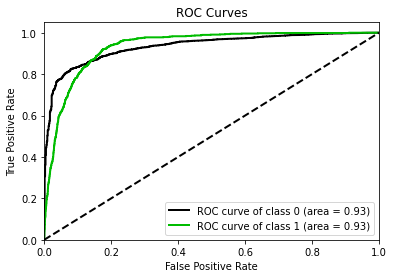

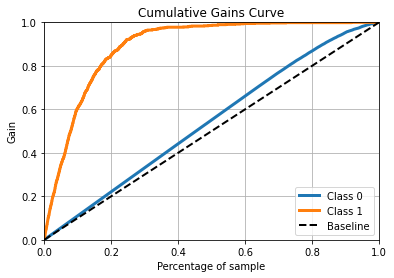

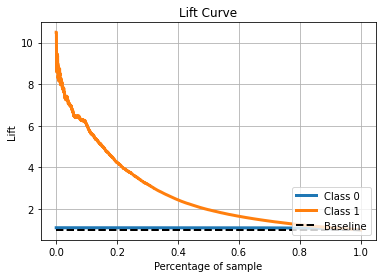

In [225]:
#XG boost curves

skplt.metrics.plot_roc(y_test, clf_tuned_xg.predict_proba(X_test), plot_micro =False, plot_macro = False)

skplt.metrics.plot_cumulative_gain(y_test, clf_tuned_xg.predict_proba(X_test))

skplt.metrics.plot_lift_curve(y_test, clf_tuned_xg.predict_proba(X_test))

plt.show()